In [3]:
#Importar librerias
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer

Text(0, 0.5, 'Mega Watts')

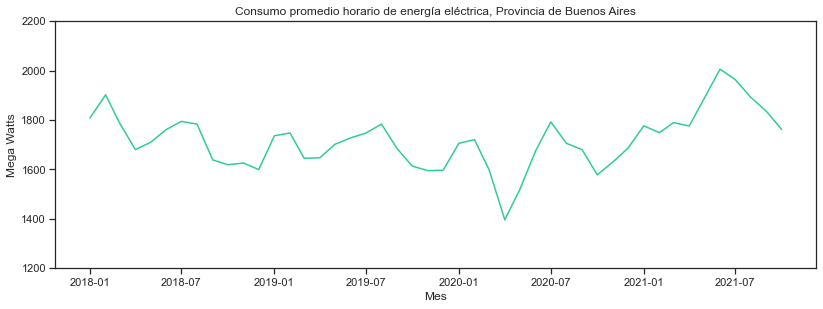

In [171]:
#import '"Fuente chart.xlsx"
df = pd.read_excel('Fuente chart.xlsx')
#Plot Fuente chart series in different plots, y axis starting from 1000
plt.figure(figsize=(30,10))
plt.subplot(2,2,1)
sns.lineplot(x='Fecha', y='Energia BSAS', data=df,  color='#2ecc95')
#Change y axis starting from 1000
plt.ylim(1200,2200)
plt.title('Consumo promedio horario de energía eléctrica, Provincia de Buenos Aires')
plt.xlabel('Mes')
plt.ylabel('Mega Watts')

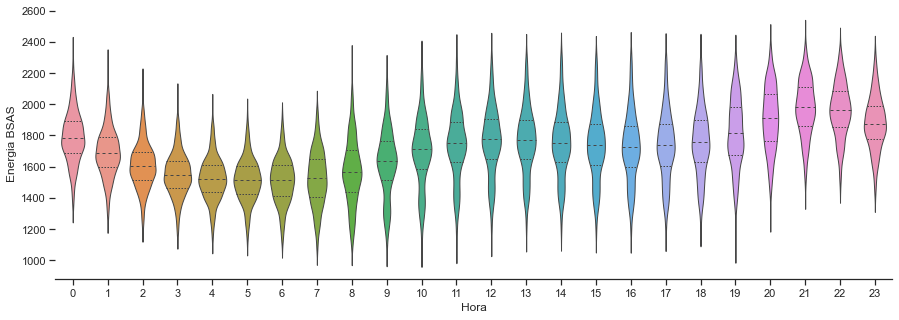

In [152]:
#Plot distribución por horas
plt.figure(figsize=(15,5))
sns.set_theme(style="ticks", palette="pastel")
sns.violinplot(data=df, x=df["Hora"], y=df["Energia BSAS"],
               split=True, inner="quart", linewidth=1)
sns.despine(left=True)

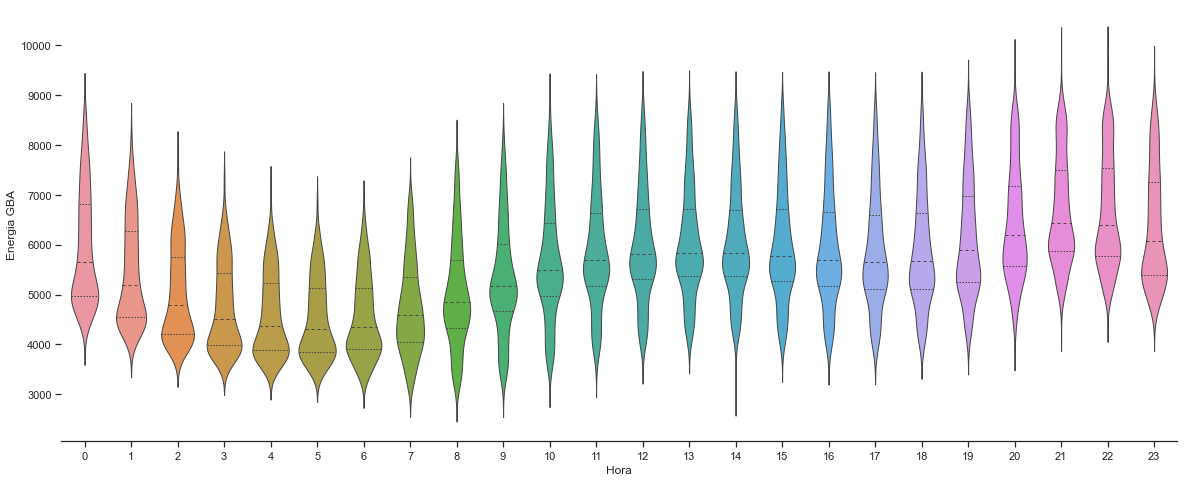

In [90]:
#Plot distribución por horas
plt.figure(figsize=(20,8))
sns.set_theme(style="ticks", palette="pastel")
sns.violinplot(data=df, x=df["Hora"], y=df["Energia GBA"],
               split=True, inner="quart", linewidth=1)
sns.despine(left=True)

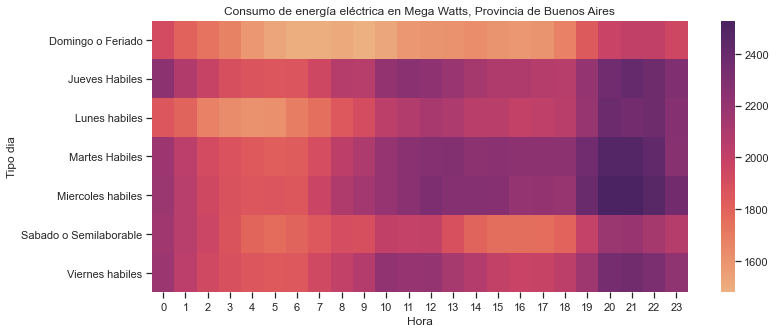

In [164]:
#Import BSASok.xls
series = pd.read_excel('BSASok.xls')
series2 = series[-168:]
series2 = series2.pivot("Tipo dia", "Hora", "Mega Watts/hora")

#Size of the plot
plt.figure(figsize=(12,5))
plt.title('Consumo de energía eléctrica en Mega Watts, Provincia de Buenos Aires')
ax = sns.heatmap(series2, cmap="flare", fmt=".0f")



<h1> Data cleaning</h1>

Importar el csv con consumo de energia (MW) y Temperatura (C°) con el fin de:
* Visualizar datos.
* Identificar outliers y removerlos.
* Tratar los valores nulos.
* Comprobar si fueron resueltos los problemas.

In [4]:
# Importar csv que posee Consumo de energia y Temperatura de 23 provincias + CABA.
df = pd.read_csv("BASE.csv", header = 0, parse_dates = [0], index_col = 0, dayfirst=True) 
df = df.iloc[:,:6] # Seleccionar la información para la Provincia de Buenos Aires y GBA.
df['Año'] = pd.DatetimeIndex(df.index).year
df['Mes'] = pd.DatetimeIndex(df.index).month
#split dataframe before september 2021
df = df[df.index < '2021-09-01 00:00:00']
df.tail()

,Hora,Tipo Dia,Energia BSAS,Clima BSAS,Energia GBA,Clima GBA,Año,Mes
Fecha,,,,,,,,
2021-08-31 19:00:00,19,3,1869.038,19.5,5511.642,19.5,2021,8
2021-08-31 20:00:00,20,3,2012.209,19.4,5980.252,19.4,2021,8
2021-08-31 21:00:00,21,3,2023.725,20.0,6096.688,20.0,2021,8
2021-08-31 22:00:00,22,3,1937.801,19.1,5955.714,19.1,2021,8
2021-08-31 23:00:00,23,3,1821.550,19.0,5490.539,19.0,2021,8


In [15]:
#Estadisticas descriptivas
df.describe()

,Hora,Tipo Dia,Energia BSAS,Clima BSAS,Energia GBA,Clima GBA,Año,Mes
count,32856.000000,32856.000000,32136.000000,32856.000000,32136.000000,32856.000000,32856.000000,32856.000000
mean,11.500000,3.902849,1714.984941,18.320718,5644.182359,18.320718,2019.399562,6.222060
std,6.922292,2.065448,235.764638,6.390934,1243.211602,6.390934,1.082596,3.348185
min,0.000000,1.000000,1054.673000,0.000000,2952.547000,0.000000,2018.000000,1.000000
25%,5.750000,2.000000,1545.590000,13.600000,4713.455250,13.600000,2018.000000,3.000000
50%,11.500000,4.000000,1707.024500,18.200000,5520.970500,18.200000,2019.000000,6.000000
75%,17.250000,6.000000,1874.303250,22.900000,6424.154750,22.900000,2020.000000,9.000000
max,23.000000,7.000000,2455.935000,37.300000,9863.211000,37.300000,2021.000000,12.000000


In [16]:
# Hay NaN?
df.isna().sum()

Hora              0
Tipo Dia          0
Energia BSAS    720
Clima BSAS        0
Energia GBA     720
Clima GBA         0
Año               0
Mes               0
dtype: int64

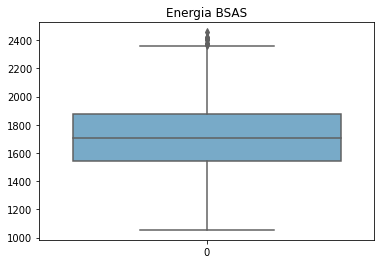

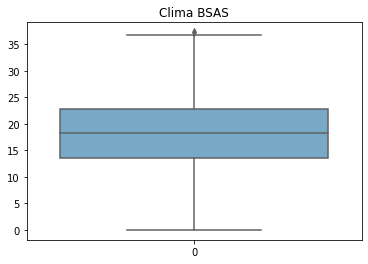

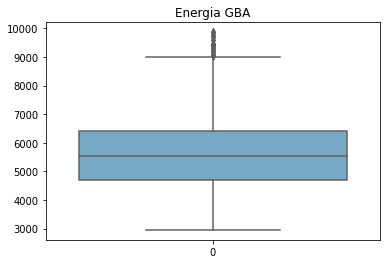

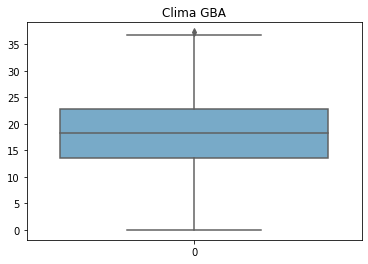

In [17]:
#Graficos de boxplot para evaluar la existencia de outliers color azul

for column in df.columns[2:6]:
    plt.figure()
    sns.boxplot(data=df[column], palette="Blues").set_title(column)


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Text(0.5, 1.0, 'Consumo de energía eléctrica horario, Gran Buenos Aires')

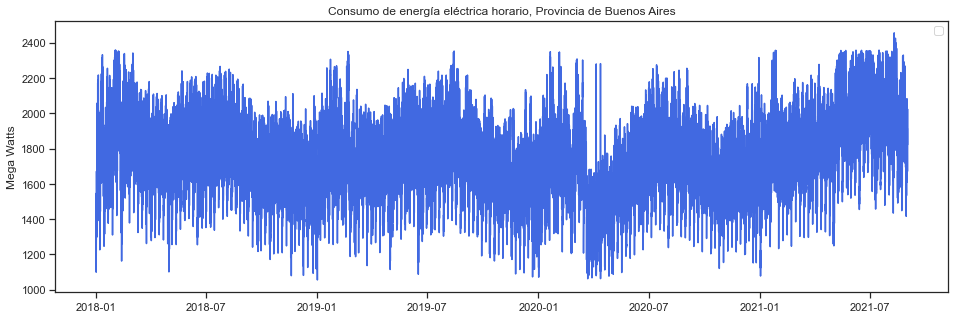

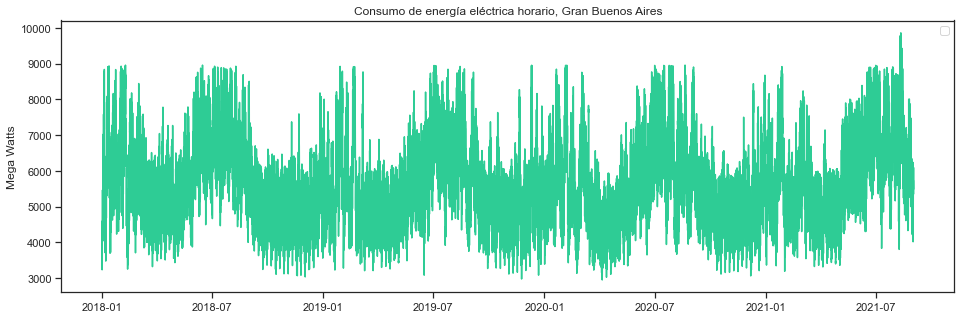

In [203]:
#Plot 'Energia GBA' in one plot and 'Energia BSAS' in another plot as series
plt.figure(figsize=(16,5))
#Color blue for 'Energia BSAS'
plt.plot(df['Energia BSAS'], color= '#4169e1')
plt.ylabel('Mega Watts')
plt.legend()
plt.title('Consumo de energía eléctrica horario, Provincia de Buenos Aires')


plt.figure(figsize=(16,5))
plt.plot(df['Energia GBA'], color='#2ecc95')
plt.ylabel('Mega Watts')
plt.legend()
plt.title('Consumo de energía eléctrica horario, Gran Buenos Aires')


### Hace falta corregir la existencia de outliers para los datos de energia y valores nulos para el caso de la temperatura.
### Para el tratamiento de outliers consideramos dos opciones: z-score e IQR.\
### Al no ser distribuciones perfectamente normales en todos los casos, utilizamos el IQR.


array([[<AxesSubplot:title={'center':'Energia BSAS'}>,
        <AxesSubplot:title={'center':'Clima BSAS'}>],
       [<AxesSubplot:title={'center':'Energia GBA'}>,
        <AxesSubplot:title={'center':'Clima GBA'}>]], dtype=object)

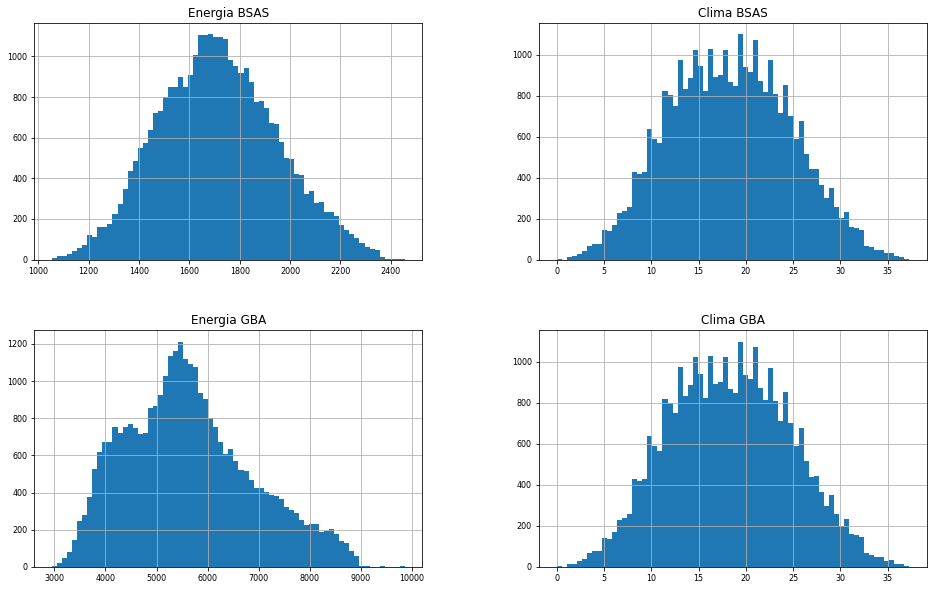

In [7]:
#Histogramas
df.iloc[:,2:6].hist(figsize=(16, 10), bins=70, xlabelsize=8, ylabelsize=8)

In [8]:
#Calculo del rango intercuartil
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Hora              11.50000
Tipo Dia           4.00000
Energia BSAS     328.71325
Clima BSAS         9.30000
Energia GBA     1710.69950
Clima GBA          9.30000
Año                2.00000
Mes                6.00000
dtype: float64


In [9]:
#Reemplazar outliers con NaN utilizando el IQR

df = df.mask((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR)), np.nan)
df.isna().sum()

Hora              0
Tipo Dia          0
Energia BSAS    731
Clima BSAS        1
Energia GBA     736
Clima GBA         1
Año               0
Mes               0
dtype: int64

In [2]:
#split dataframe before september 2021
df_before = df[df.index < '2021-09-01']
#drop energia bsas
df_before = df_before.drop(['Energia BSAS'], axis=1)
#drop energia bsas from df
df = df.drop(['Energia BSAS'], axis=1)
df_before.tail()

NameError: name 'df' is not defined

#### Fueron removidos los outliers, para completar los valores nulos se prueban distintos metodos, dando mejor resultado el KNN.

In [77]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

rmse = lambda y, yhat: np.sqrt(mean_squared_error(y, yhat))
def optimize_k(data, target):
    errors = []
    for k in range(1, 20, 2):
        imputer = KNNImputer(n_neighbors=k)
        imputed = imputer.fit_transform(data)
        df_imputed = pd.DataFrame(imputed, columns=df.columns)
        
        X = df_imputed.drop(target, axis=1)
        y = df_imputed[target]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

        model = RandomForestRegressor()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        error = rmse(y_test, preds)
        errors.append({'K': k, 'RMSE': error})
        
    return errors

In [114]:
#Fill NaN using LightGBM
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
#Create function to optimize lightgbm parameters
def optimize_lgbm(data, target):
    errors = []
    for max_depth in range(1, 20, 2):
        for num_leaves in range(10, 20, 2):
            for learning_rate in [0.01, 0.05, 0.01]:
                model = LGBMRegressor(max_depth=max_depth, num_leaves=num_leaves, learning_rate=learning_rate)
                model.fit(data, target)
                preds = model.predict(data)
                error = rmse(target, preds)
                errors.append({'max_depth': max_depth, 'num_leaves': num_leaves, 'learning_rate': learning_rate, 'RMSE': error})
    return errors


In [116]:
#Use lightbm function data= data_before, target= 'Energia GBA'
errors = optimize_lgbm(data=df_before, target= df_before['Energia GBA'])
errors = pd.DataFrame(errors)
#sort errors by RMSE
errors = errors.sort_values(by='RMSE', ascending= True)
#print top 5 errors
errors.head()

,max_depth,num_leaves,learning_rate,RMSE
58,7,18,0.05,14.624154
118,15,18,0.05,14.663808
103,13,18,0.05,14.663808
148,19,18,0.05,14.663808
133,17,18,0.05,14.663808


In [117]:
# Importar csv que posee Consumo de energia y Temperatura de 23 provincias + CABA.
df = pd.read_csv("BASE.csv", header = 0, parse_dates = [0], index_col = 0, dayfirst=True) 
df = df.iloc[:,:6] # Seleccionar la información para la Provincia de Buenos Aires y GBA.
df['Año'] = pd.DatetimeIndex(df.index).year
df['Mes'] = pd.DatetimeIndex(df.index).month
#Drop energia bs as
df = df.drop(['Energia BSAS'], axis=1)

<AxesSubplot:xlabel='Fecha'>

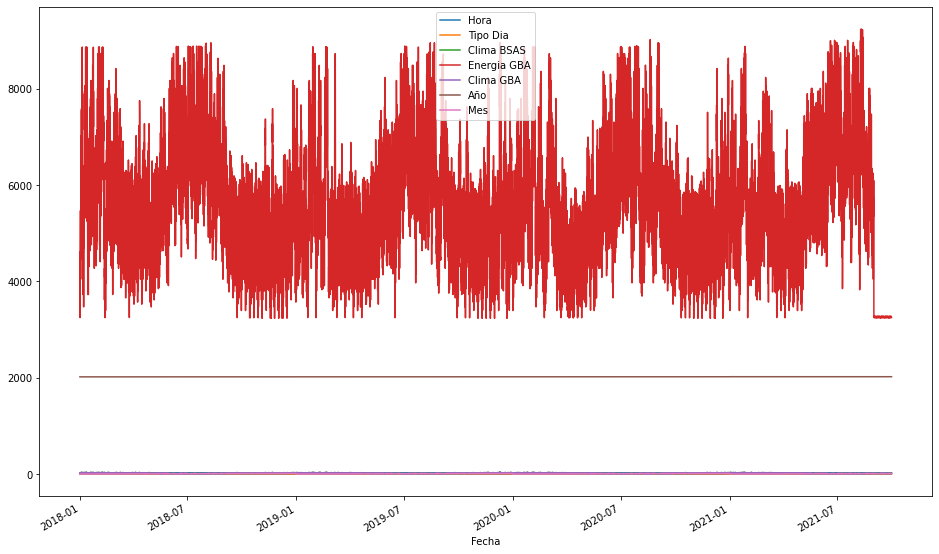

In [126]:
#Fill NaN using lightgbm with best parameters found in errors dataframe
model = LGBMRegressor(max_depth=7, num_leaves=18, learning_rate=0.05)
model.fit(df_before, df_before['Energia GBA'])
preds = model.predict(df)
df['Energia GBA'] = preds

In [119]:
#df to csv
df.to_csv('BASE_imputed.csv')

In [52]:
k_errors = optimize_k(data=df_before, target='Energia BSAS')

In [53]:
#Muestra el RMSE de los errores para diferentes k
pd.DataFrame.from_dict(k_errors, orient='columns', dtype=None, columns=None)

,K,RMSE
0,1,57.422877
1,3,57.081414
2,5,57.417396
3,7,55.912034
4,9,56.733919
5,11,58.770008
6,13,58.428991
7,15,55.914082
8,17,58.018159
9,19,57.485663


In [54]:
# Completar los valores nulos utilizando KNN, con k=5
imputer = KNNImputer(n_neighbors=15)
df1 = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

In [88]:
df1.set_index(df.index, inplace=True)
df = df1
df.tail()

,Hora,Tipo Dia,Energia BSAS,Clima BSAS,Energia GBA,Clima GBA,Año,Mes
Fecha,,,,,,,,
2021-09-30 19:00:00,19.0,5.0,1769.703733,16.8,5595.383400,16.8,2021.0,9.0
2021-09-30 20:00:00,20.0,5.0,1916.150133,16.9,6042.890667,16.9,2021.0,9.0
2021-09-30 21:00:00,21.0,5.0,1930.411000,16.9,6014.421000,16.9,2021.0,9.0
2021-09-30 22:00:00,22.0,5.0,1887.676733,16.9,5986.037867,16.9,2021.0,9.0
2021-09-30 23:00:00,23.0,5.0,1877.744400,16.4,5899.259867,16.4,2021.0,9.0


#### Fueron probados tambien los siguientes metodos:

* Repetimos el proceso de visualización para identificar si fueron resueltos los problemas en las series de tiempo

In [57]:
#Exportar csv sin outliers para el modelo
df.to_csv("BASEo.csv")

In [31]:
df.isna().sum()

Hora            0
Tipo Dia        0
Energia BSAS    0
Clima BSAS      0
Energia GBA     0
Clima GBA       0
Año             0
Mes             0
dtype: int64

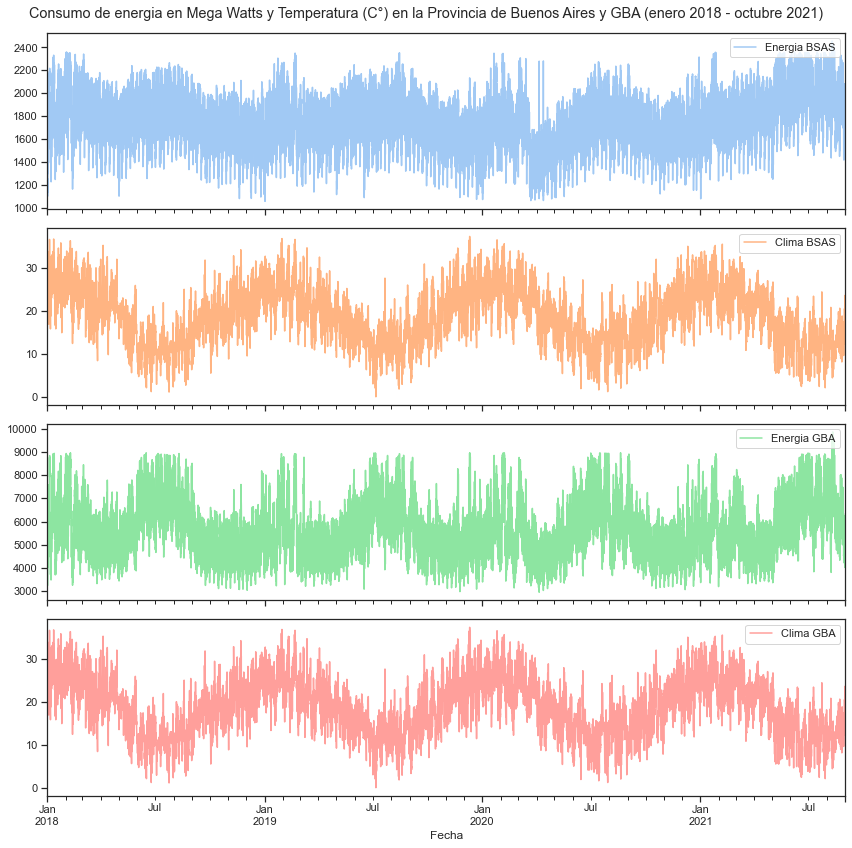

In [209]:
df[['Energia BSAS', 'Clima BSAS', 'Energia GBA', 'Clima GBA']].plot(subplots = True, figsize = (12,12))
[ax.legend(loc = 1) for ax in plt.gcf().axes]
plt.suptitle('Consumo de energia en Mega Watts y Temperatura (C°) en la Provincia de Buenos Aires y GBA (enero 2018 - octubre 2021)')
plt.tight_layout()
plt.subplots_adjust(top = 0.95)

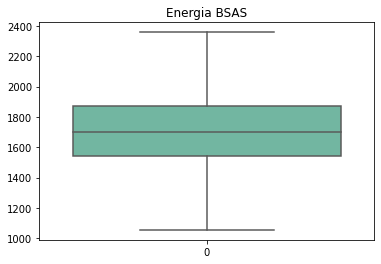

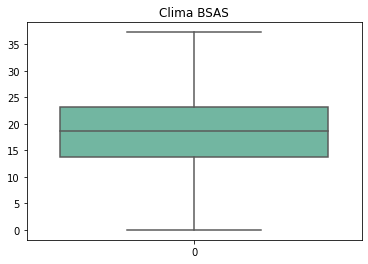

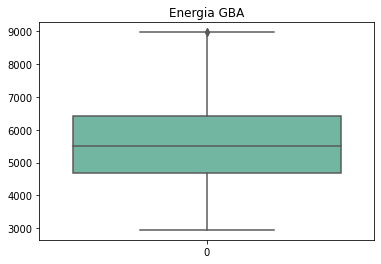

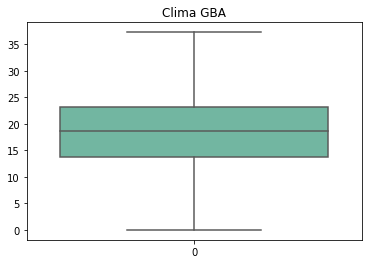

In [119]:
#Graficos de boxplot 
for column in df.columns[2:6]:
    plt.figure()
    sns.boxplot(data=df[column], palette="Set2").set_title(column)

array([[<AxesSubplot:title={'center':'Energia BSAS'}>,
        <AxesSubplot:title={'center':'Clima BSAS'}>],
       [<AxesSubplot:title={'center':'Energia GBA'}>,
        <AxesSubplot:title={'center':'Clima GBA'}>]], dtype=object)

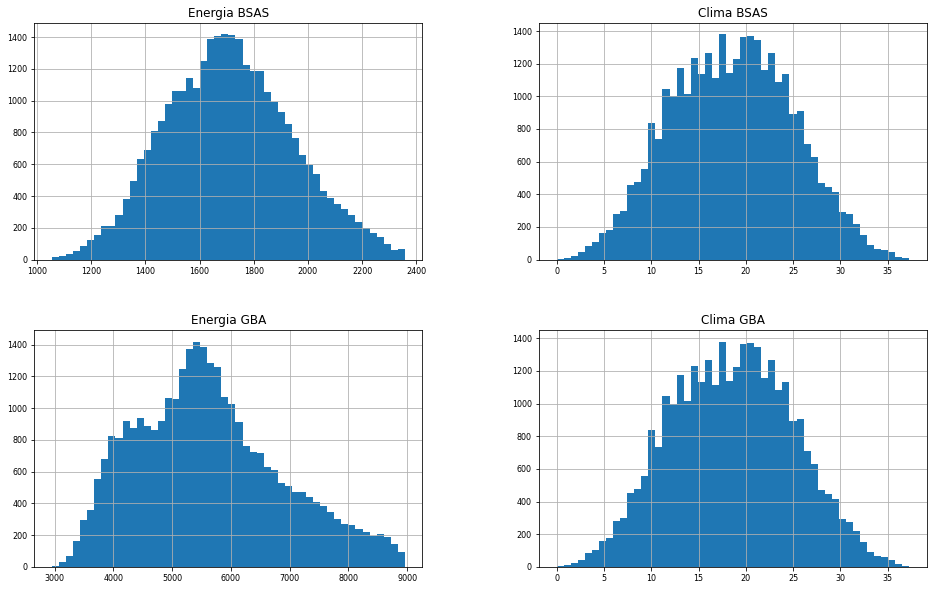

In [120]:
#Distribuciones
df.iloc[:,2:6].hist(figsize=(16, 10), bins=50, xlabelsize=8, ylabelsize=8)

<h1> Análisis de datos - GBA</h1>

Este apartado tiene como objetivo buscar insight en los datos que permitan definir algunas especificaciones del modelo

In [146]:
df

,Hora,Tipo Dia,Energia BSAS,Clima BSAS,Energia GBA,Clima GBA,Año,Mes
Fecha,,,,,,,,
2018-01-01 00:00:00,0.0,1.0,1544.873,19.2,4593.287,19.2,2018.0,1.0
2018-01-01 01:00:00,1.0,1.0,1425.868,18.6,4384.859,18.6,2018.0,1.0
2018-01-01 02:00:00,2.0,1.0,1387.791,18.5,4266.546,18.5,2018.0,1.0
2018-01-01 03:00:00,3.0,1.0,1327.708,17.9,4103.462,17.9,2018.0,1.0
2018-01-01 04:00:00,4.0,1.0,1268.554,17.5,3912.347,17.5,2018.0,1.0
...,...,...,...,...,...,...,...,...
2021-07-31 19:00:00,19.0,7.0,1993.628,11.6,6638.925,11.6,2021.0,7.0
2021-07-31 20:00:00,20.0,7.0,2179.763,9.9,7349.056,9.9,2021.0,7.0
2021-07-31 21:00:00,21.0,7.0,2185.000,9.0,7698.634,9.0,2021.0,7.0


In [1]:
#Distribuciones por Año
df1 = df
for año in df1['Año'].unique():
    df1[(df1['Año'] == año) & (df['Mes'] < 9)]['Energia GBA'].plot(kind='density', figsize = (12,7), legend = True, label = año)
    _ = plt.xlabel('Consumo de energia en MWH')
    _ = plt.title('Variación en la distribucion del consumo de energia para el periodo 2018 - 2021')

NameError: name 'df' is not defined

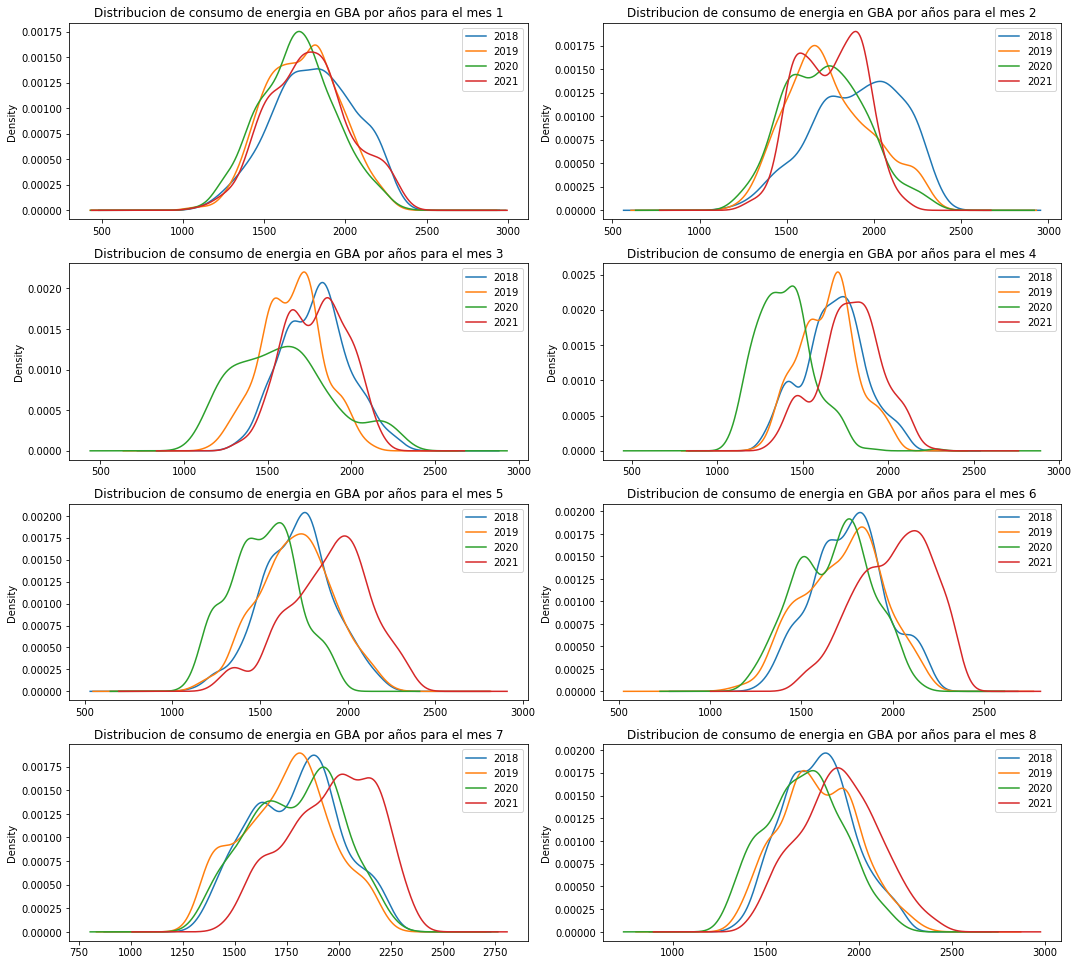

In [9]:
#Distribuciones por mes
f = plt.figure(figsize = (15,40))
mes = np.arange(1, 9) #Solo considera los primeros 8 meses del año, para los que tenemos datos en el 2021
for i, mes in enumerate(mes):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(df['Año'].unique()):
        df[(df['Año'] == year) & (df['Mes'] == mes)]['Energia BSAS'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
    plt.title('Distribucion de consumo de energia en GBA por años para el mes '+str(mes))

plt.tight_layout()

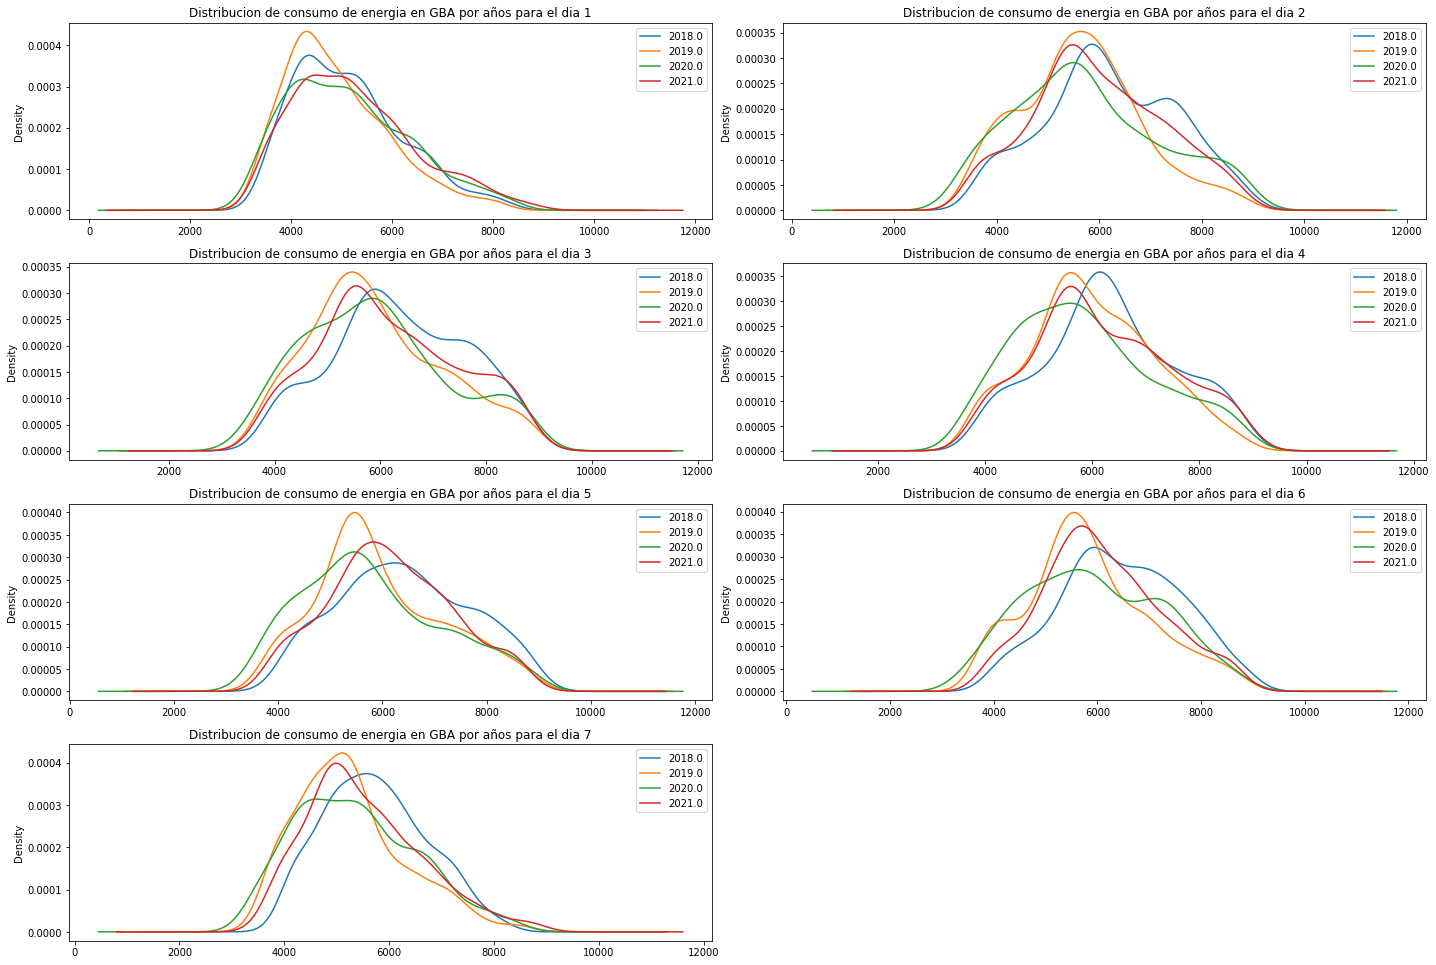

In [152]:
#Distribuciones por dia de la semana, para los primeros 7 meses del año
f = plt.figure(figsize = (20,40))
tipo_dia = np.arange(1,9) 
for i, dia in enumerate(tipo_dia):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(df['Año'].unique()):
        df[(df['Año'] == year) & (df['Tipo Dia'] == dia) & (df['Mes'] < 8)]['Energia GBA'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
    plt.title('Distribucion de consumo de energia en GBA por años para el dia '+str(dia))
plt.tight_layout()

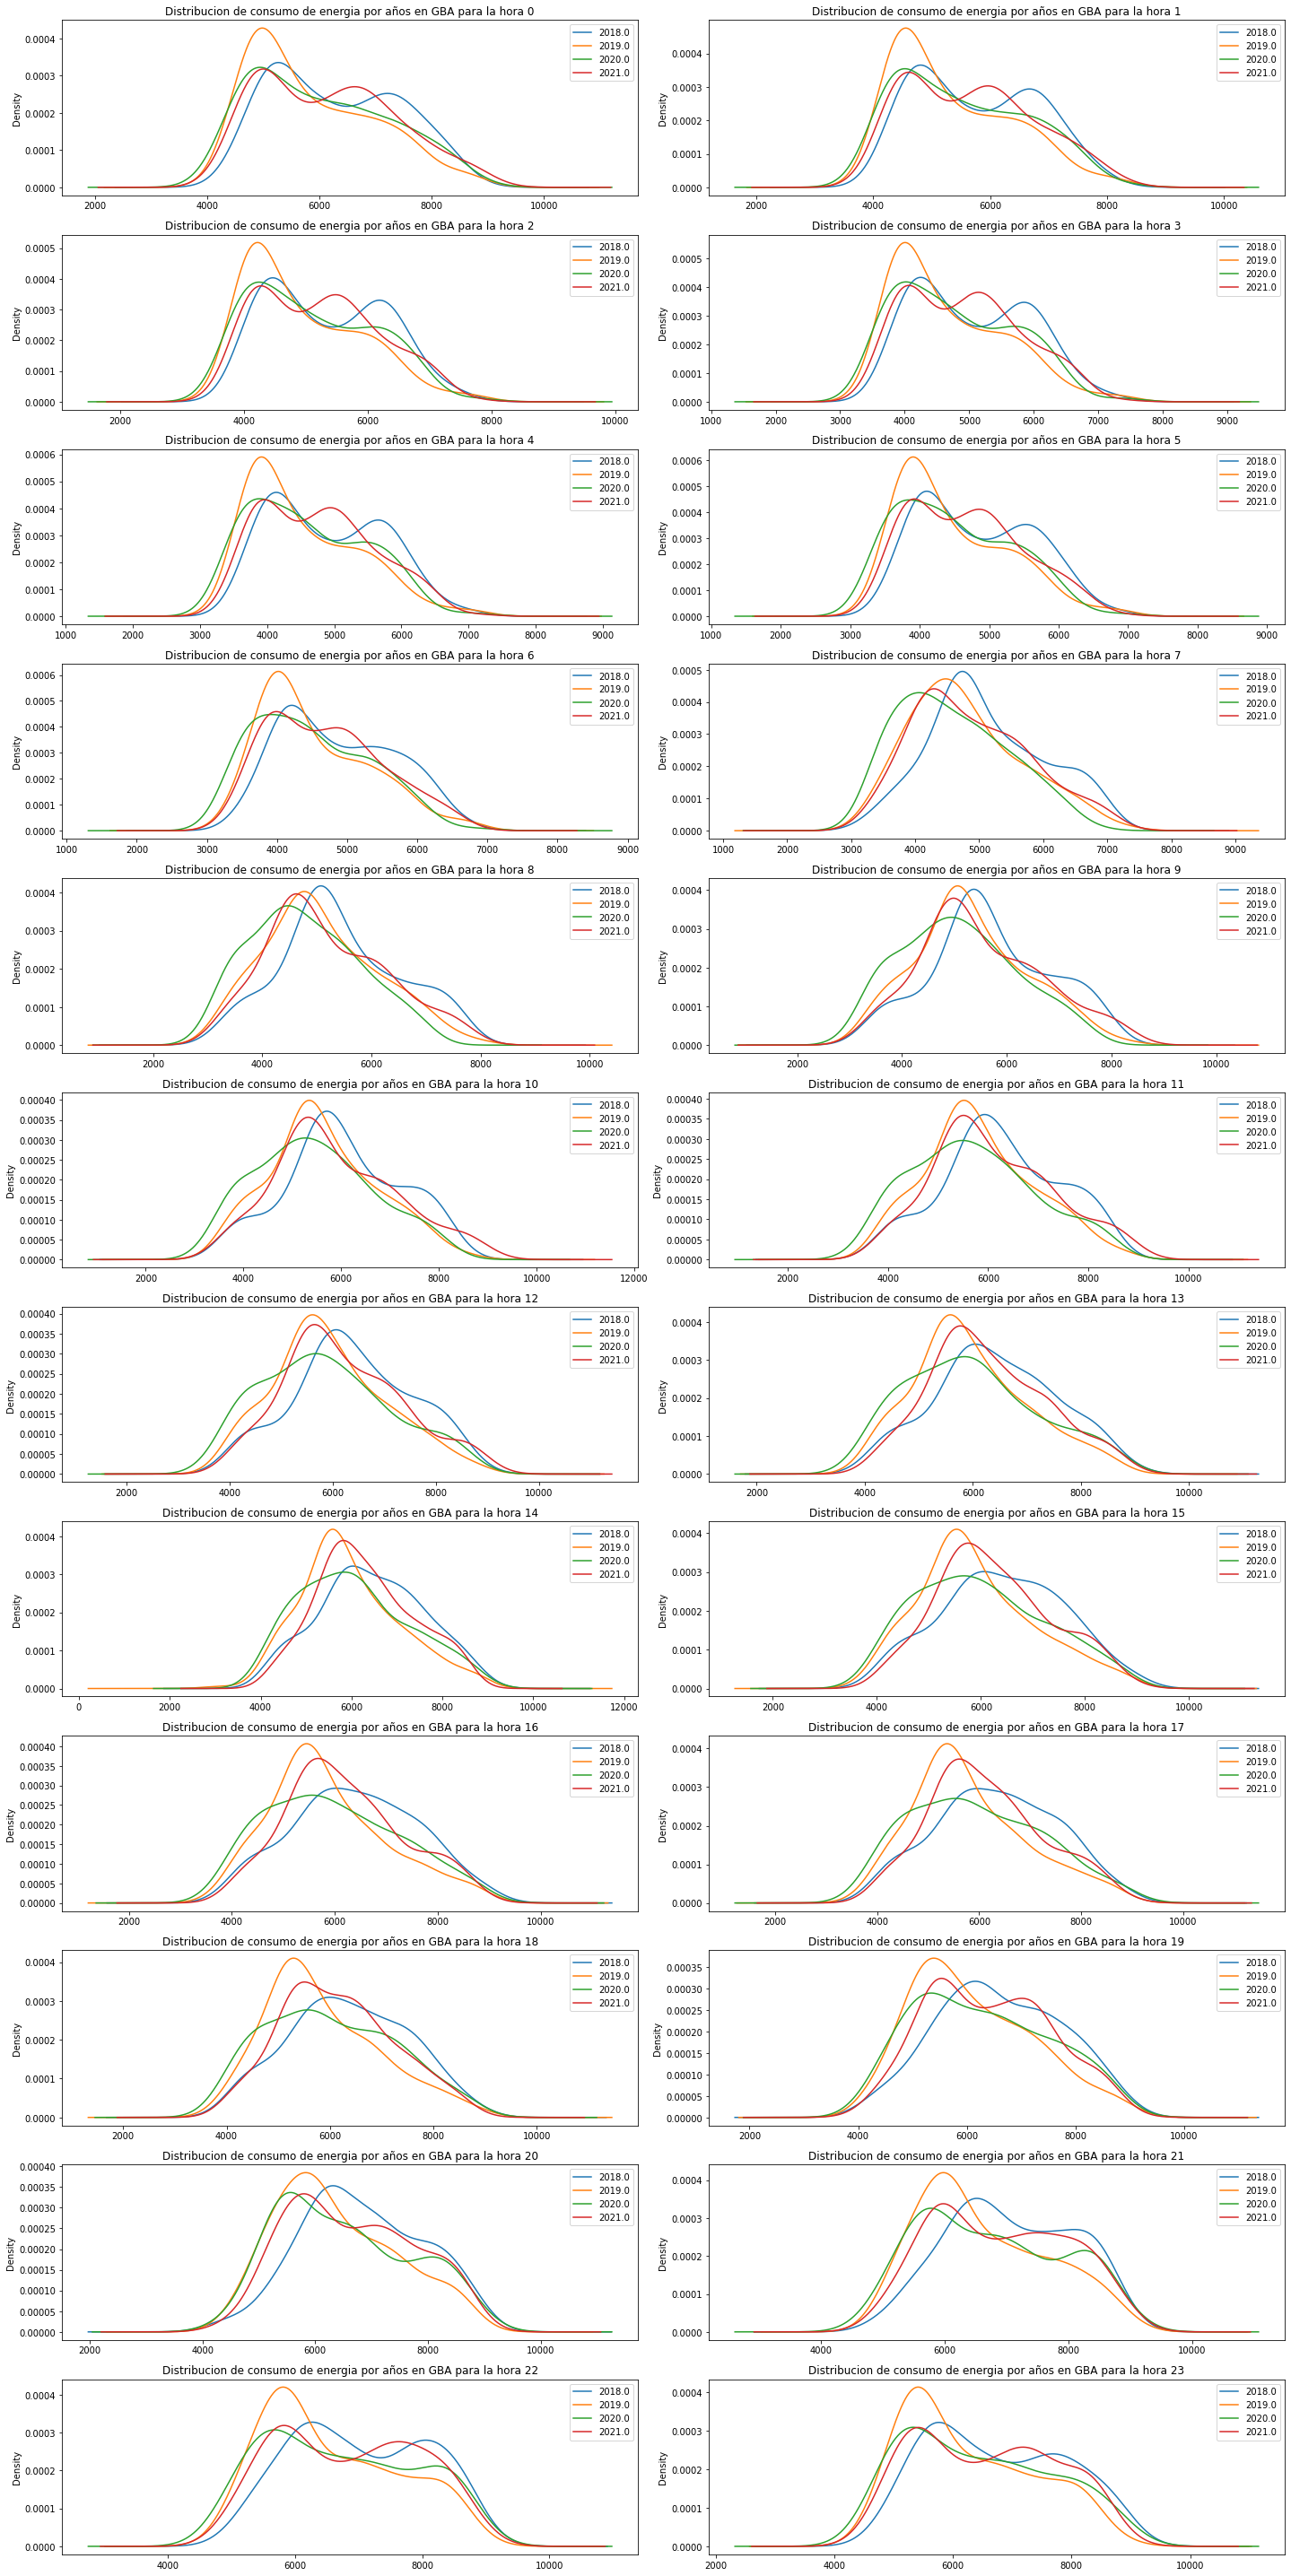

In [19]:
#Distribuciones por hora del dia
f = plt.figure(figsize = (20,40))
peak_hours = np.arange(0,24) 
for i, hour in enumerate(peak_hours):
    ax = f.add_subplot(12,2,i+1)
    for j, year in enumerate(df['Año'].unique()):
        df[(df['Año'] == year) & (df['Hora'] == hour) & (df['Mes'] < 9)]['Energia GBA'].\
                                plot(kind='density',  sharey=False, legend=True, label= year)
    plt.title('Distribucion de consumo de energia por años en GBA para la hora '+str(hour))
plt.tight_layout()